# Customer Segmentation using K-Means Algorithm for Seasonal Profiles

The individual files should contain 3 months data of energy consumption in 15 minute interval

In [14]:
import polars as pl
import glob
from pathlib import Path
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import logging
import re
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation
from Hyperparameters_KMeans import optimize_kmeans

## Select the season for clustering

In [15]:
season = "summer"

pattern = f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_seasonal_normalized/SM_DATA_seasonal_normalized_{season}/*CH*.csv"
file_paths = glob.glob(pattern)

print(f"Number of files for season {season}: {len(file_paths)}")

Number of files for season summer: 1481


In [16]:
n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data_summer = data_3d



Shape of the 3D array: (1481, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [17]:
n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =200
n_init = 5

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=False, random_state=42,n_init=n_init, n_jobs=-1)
clusters_train_summer = kmeans.fit_predict(train_data_summer)


In [18]:
print(clusters_train_summer)

remap = {1: 0, 3: 1, 2: 2, 0: 3} #summer
clusters_train_summer = np.vectorize(remap.get)(clusters_train_summer)

print(clusters_train_summer)


[3 1 1 ... 3 1 3]
[1 0 0 ... 1 0 1]


In [19]:
season = "winter"

pattern = f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_seasonal_normalized/SM_DATA_seasonal_normalized_{season}/*CH*.csv"
file_paths = glob.glob(pattern)

print(f"Number of files for season {season}: {len(file_paths)}")

Number of files for season winter: 1481


In [20]:
n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data_winter = data_3d



Shape of the 3D array: (1481, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [33]:
n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =200
n_init = 5

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=False, random_state=42,n_init=n_init, n_jobs=-1)
clusters_train_winter = kmeans.fit_predict(train_data_winter)

print(type(clusters_train_winter))


<class 'numpy.ndarray'>


In [22]:
print(clusters_train_winter)

remap = {3: 0, 0: 1, 2: 2, 1: 3} #winter
clusters_train_winter = np.vectorize(remap.get)(clusters_train_winter)

print(clusters_train_winter)



[0 0 3 ... 0 3 0]
[1 1 0 ... 1 0 1]


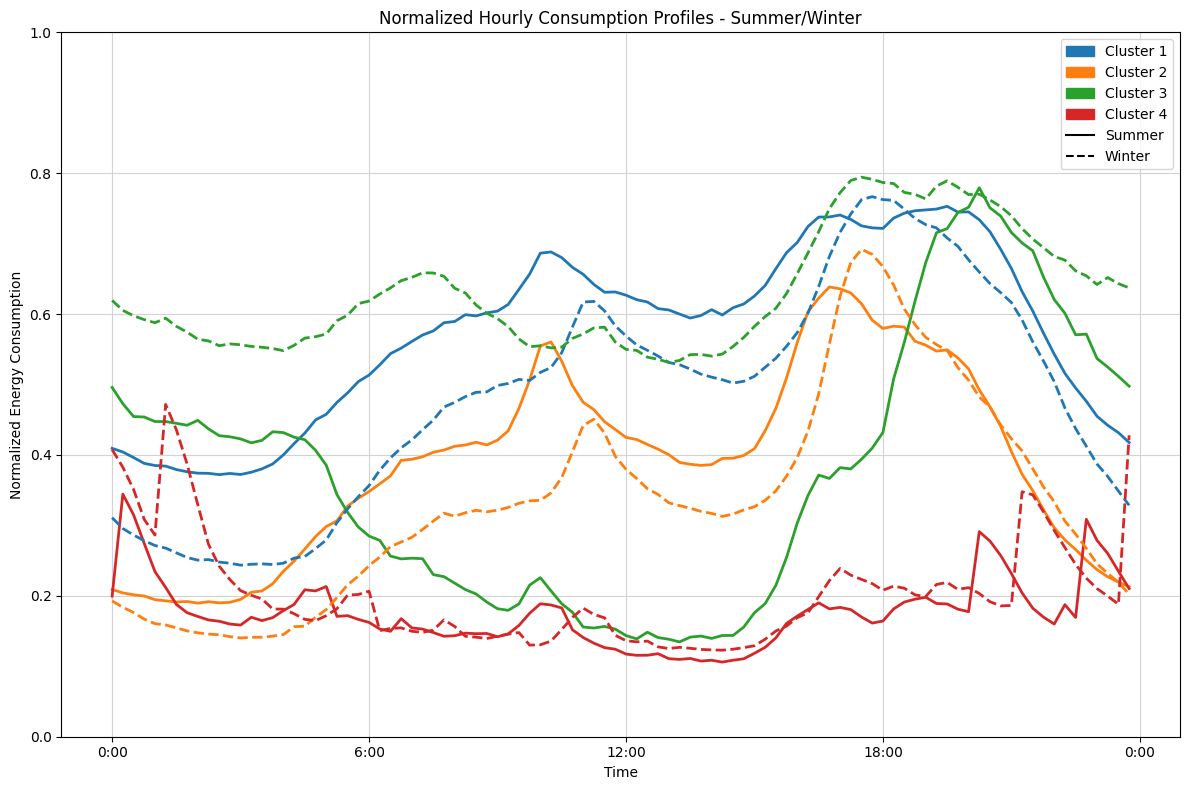

In [32]:

labels = ['0:00','6:00','12:00','18:00','0:00']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']
color_patches = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(n_clusters)]

def plot_clusters_season():
    plt.figure(figsize=(12,8))

    # First: plot solid lines (set 1)
    for cluster_idx in range(n_clusters):
        cluster_data_summer = train_data_summer[clusters_train_summer == cluster_idx]
        mean_time_series = np.mean(cluster_data_summer, axis=0)
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'Cluster {cluster_idx+1} (Set 1)',
                linewidth=2, color=colors[cluster_idx], linestyle='solid')

    # Second: plot dashed lines (set 2)
    for cluster_idx in range(n_clusters):
        cluster_data_winter = train_data_winter[clusters_train_winter == cluster_idx]
        mean_time_series_2 = np.mean(cluster_data_winter, axis=0)
        plt.plot(range(1,97), mean_time_series_2.ravel(), 
                label= f'Cluster {cluster_idx+1} (Set 2)',
                linewidth=2, color=colors[cluster_idx], linestyle='dashed')

    plt.title(f'Normalized Hourly Consumption Profiles - Summer/Winter')
    plt.xlabel("Time")
    plt.ylabel("Normalized Energy Consumption")
    plt.ylim(0,1)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    plt.grid(True, color = 'lightgray')
    
    solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='Summer')
    dashed_line = mlines.Line2D([], [], color='black', linestyle='dashed', label='Winter')


    plt.legend(handles=color_patches + [solid_line, dashed_line], loc='upper right', fontsize='medium')

    plt.savefig(
        "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/seasonal_clusters_summer_winter.png",
        bbox_inches='tight'
    )
    plt.show()

plot_clusters_season()